In [2]:
import numpy as np # for handling matrices

from qutip import * # for handling quantum mechanical operators, vectors, ...
import matplotlib.pyplot as plt

import time
import random as rand

import networkx as nx

In [2]:
# it is useful to construct an empty operator in the 2^N dimensional Hilbert space
def operator_list(N): 
    op_list = []
    for i in range(N):
        op_list.append(qeye(2)) 
    return op_list # the return must still be put into the tensor() function later

In [3]:
# define the problem/driver hamiltonian; J is the interaction matrix of the all-to-all spin glass, b magnetic field
def H_problem(J, offset, b): # the offset is to facilitate the formulation for MaxCut
    N = len(J) # is the number of qubits - the dimension of the Hilbert space is then 2^N
    H_p = 0 # initialize the problem hamiltonian with zero
    
    for i in range(1,N+1,1):
        op_list_2 = operator_list(N) # list in which the operators are stored for every magnetic field
        op_list_2[i-1] = sigmaz() # the ith entry are stores the sigmaz pauli-matrix
        for j in range(i+1,N+1,1):
            op_list_1 = operator_list(N) # list in which the operators are stored for every entry (i,j) of J
            op_list_1[i-1] = sigmaz() # the ith and jth entry are stored with the sigmaz() pauli-matrix
            op_list_1[j-1] = sigmaz()
            
            # iteratively construct the hamiltonian
            H_p = H_p + offset * tensor(operator_list(N)) + J[i-1,j-1] * tensor(op_list_1) 
        H_p = H_p + b[i-1] * tensor(op_list_2)
    return H_p

In [4]:
# define the initial hamiltonian whose eigenstates are easy to construct, N is the number of qubits
def H_initial(N):
    H_0 = 0 # initialize the initial hamiltonian with zero
    
    for i in range(1,N+1,1):
        op_list = operator_list(N) # list in which the operators are stored for qubit
        op_list[i-1] = sigmax()
        
        H_0 = H_0 + tensor(op_list)
    return H_0

In [5]:
# define the time dependent hamiltonian which models the transition from H_0 to H_p
def H_time(t, t_max, H_0, H_p):
    return (1 - t / t_max) * H_0 + (t / t_max) * H_p

In [6]:
def solve_H_time(t_max, iterations, H_0, H_p, N):
    t = np.linspace(0, t_max, iterations)
    
    evals_mat = np.zeros((len(t),2**N)) # matrix for storing the eigenvalues
    for i in range(len(t)):
        H_t = H_time(t[i], t_max, H_0, H_p)
        
        evals, ekets = H_t.eigenstates() # calculate the eigenvalues and eigenstates
        evals_mat[i,:] = np.real(evals)

    return evals_mat.T

In [7]:
def von_neumann_entropy_state(state):
    entropy = 0
    for i in range(state.shape[0]):
        entropy = entropy + (state[i,0] * np.conj(state[i,0])).real * np.log((state[i,0] * np.conj(state[i,0])).real)
    return -entropy

In [8]:
def U_H(H, angle):
    exponential = (-1j*angle*H)
    return exponential.expm()

In [9]:
def monte_carlo_update_state(initial_ket, H_p, p, params):
    evolved_ket = initial_ket
    for i in range(p):
        evolved_ket = U_H(H_0, params[i+1]) * U_H(H_p, params[i]) * evolved_ket    
    expectation_value = (evolved_ket.dag() * H_p * evolved_ket)[0,0].real
    
    return evolved_ket, expectation_value

In [10]:
def get_random_params(params, choice):
    if choice == "lechner_approach":
        rand_param = rand.randint(0,len(params)-1) # generate random index corresponding to random param
        params[rand_param] = 2*np.pi*rand.random() # generators random number in [0,2*pi]
    elif choice == "all_approach":  
        params = 2*np.pi*np.random.rand(len(params)) # generate random array of size 2*p in intervall [0,2*pi]
    return params

In [11]:
def qaoa_protocoll_montecarlo(H_0, H_p, p, M, random_approach, opt_approach):
    initial_evals, initial_ekets = H_0.eigenstates() # calculate eigenvalues and eigenstates
    highest_eval = initial_evals[len(initial_evals)-1] #  last entry is the highest eigenvalue

    initial_ket = initial_ekets[len(initial_evals)-1] # superposition of all |z> vectors - one of them must include the solution
    params_init = np.zeros(2*p)
    
    exp_values = np.zeros(M+1) # initialize an array where the expecation value is defined
    entropy_values = np.zeros(M+1) # initialize an array where the entropy can be stored
    fidelity_values = np.zeros(M+1) # initialize an array where the ground state fidelities can be stored
    
    evals, ekets = H_p.eigenstates() # calculate the eigen-values and eigen-states of the problem hamiltonian
    if opt_approach == "min":
        ground_state = ekets[0]
    elif opt_approach == "max":
        ground_state = ekets[len(evals)-1]
        
    gamma_beta_state, expectation_value = monte_carlo_update_state(initial_ket, H_p, p, params_init)
    state_entropy = von_neumann_entropy_state(gamma_beta_state) # calculate entropy of amplitudes
    ground_state_fidelity = (gamma_beta_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
    
    exp_values[0] = expectation_value
    entropy_values[0] = state_entropy
    fidelity_values[0] = np.abs(ground_state_fidelity)
    
    final_state = gamma_beta_state # this is the "optimal" state at the end of the protocoll and always updated
    for i in range(M): # make monte carlo/random updating M times
        params = params_init # define help variable
        params = get_random_params(params, random_approach) # update param according to two approaches
        
        gamma_beta_state, expectation_value_n = monte_carlo_update_state(initial_ket, H_p, p, params)
        state_entropy = von_neumann_entropy_state(final_state) # calculate entropy of amplitudes
        ground_state_fidelity = (final_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
        if expectation_value_n >= expectation_value and opt_approach == "max": # just accept value if the condition is fulfilled
            params_init = params
            expectation_value = expectation_value_n
            final_state = gamma_beta_state
        elif expectation_value_n <= expectation_value and opt_approach == "min":
            params_init = params
            expectation_value = expectation_value_n
            final_state = gamma_beta_state
        exp_values[i+1] = expectation_value # store the hopefully monotonous energy change
        entropy_values[i+1] = state_entropy
        fidelity_values[i+1] = np.abs(ground_state_fidelity)
    return exp_values, params_init, entropy_values, fidelity_values, final_state 

In [12]:
def qaoa_protocoll_montecarlo_entropy(H_0, H_p, p, M, random_approach, opt_approach):
    initial_evals, initial_ekets = H_0.eigenstates() # calculate eigenvalues and eigenstates
    highest_eval = initial_evals[len(initial_evals)-1] #  last entry is the highest eigenvalue

    initial_ket = initial_ekets[len(initial_evals)-1] # superposition of all |z> vectors - one of them must include the solution
    params_init = np.zeros(2*p)
    
    exp_values = np.zeros(M+1) # initialize an array where the expecation value is defined
    entropy_values = np.zeros(M+1)
    fidelity_values = np.zeros(M+1) # initialize an array where the ground state fidelities can be stored
    
    evals, ekets = H_p.eigenstates() # calculate the eigen-values and eigen-states of the problem hamiltonian
    if opt_approach == "min":
        ground_state = ekets[0]
    elif opt_approach == "max":
        ground_state = ekets[len(evals)-1]

    gamma_beta_state, expectation_value = monte_carlo_update_state(initial_ket, H_p, p, params_init)
    state_entropy = von_neumann_entropy_state(gamma_beta_state)
    ground_state_fidelity = (gamma_beta_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
    
    exp_values[0] = expectation_value
    entropy_values[0] = state_entropy
    fidelity_values[0] = np.abs(ground_state_fidelity)
    
    final_state = gamma_beta_state # this is the "optimal" state at the end of the protocoll and always updated
    for i in range(M): # make monte carlo/random updating M times
        params = params_init # define help variable
        params = get_random_params(params, random_approach) # update param according to two approaches
        
        gamma_beta_state, expectation_value_n = monte_carlo_update_state(initial_ket, H_p, p, params)
        state_entropy_n = von_neumann_entropy_state(gamma_beta_state)
        ground_state_fidelity = (final_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
        if expectation_value_n >= expectation_value and opt_approach == "max" and state_entropy_n <= state_entropy: # just accept value if the condition is fulfilled
            params_init = params
            expectation_value = expectation_value_n
            state_entropy = state_entropy_n
            final_state = gamma_beta_state
        elif expectation_value_n <= expectation_value and opt_approach == "min" and state_entropy_n <= state_entropy:
            params_init = params
            expectation_value = expectation_value_n
            state_entropy = state_entropy_n
            final_state = gamma_beta_state
        exp_values[i+1] = expectation_value # store the hopefully monotonous energy change
        entropy_values[i+1] = state_entropy
        fidelity_values[i+1] = np.abs(ground_state_fidelity)
    return exp_values, params_init, entropy_values, fidelity_values, final_state

In [13]:
def qaoa_protocoll_scanning(H_0, H_p, gamma, beta, p):
    initial_evals, initial_ekets = H_0.eigenstates() # calculate eigenvalues and eigenstates
    highest_eval = initial_evals[len(initial_evals)-1] #  last entry is the highest eigenvalue

    initial_ket = initial_ekets[len(initial_evals)-1] # superposition of all |z> vectors - one of them must include the solution
    
    start_t = time.time()
    if p == 1:
        expectation_value = np.zeros((len(gamma), len(beta)))
        for i in range(len(gamma)):
            for j in range(len(beta)):
                gamma_beta_state = U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                expectation_value[i,j] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    elif p == 2:
        expectation_value = np.zeros((len(gamma), len(beta), len(gamma), len(beta)))
        print("Tracking of grid-scanning progress:")
        for i in range(len(gamma)):
            t = time.time()
            print("i = "+str(i)+", delta t = "+str(round(t - start_t,2))+" s")
            start_t = t
            for j in range(len(beta)):
                for k in range(len(gamma)):
                    for l in range(len(beta)):
                        gamma_beta_state = U_H(H_0, beta[l]) * U_H(H_p, gamma[k]) * U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                        expectation_value[i,j,k,l] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    elif p == 3:
        expectation_value = np.zeros((len(gamma), len(beta), len(gamma), len(beta), len(gamma), len(beta)))
        print("Tracking of grid-scanning progress:")
        for i in range(len(gamma)):
            t = time.time()
            print("i = "+str(i)+", delta t = "+str(round(t - start_t,2))+" s")
            start_t = t
            for j in range(len(beta)):
                for k in range(len(gamma)):
                    for l in range(len(beta)):
                        for m in range(len(gamma)):
                            for n in range(len(beta)):
                                gamma_beta_state = U_H(H_0, beta[n]) * U_H(H_p, gamma[m]) * U_H(H_0, beta[l]) * U_H(H_p, gamma[k]) * U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                                expectation_value[i,j,k,l,m,n] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    return expectation_value

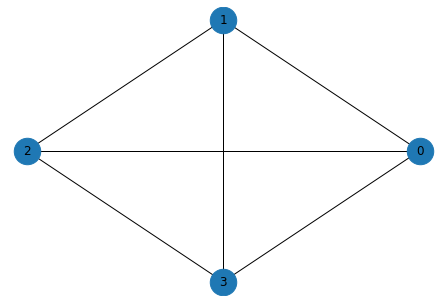

In [14]:
# specifies the interaction matrix in the all-to-all Ising spin glass
J_int = -0.5 * np.array([[0,1,1,1],
                         [1,0,1,1],
                         [1,1,0,1],
                         [1,1,1,0]]) 
# J_int = np.array([[1]]) # for 1 qubit system
# J_int = np.random.rand(4,4) # create random Ising matrix

# specifies the local magnetic fields acting on sigmaz_i
b_fields = np.array([0,0,0,0])
# b_fields = np.array([1]) # for 1 qubit system to validate the algorithm

offset = 0.5 # allows to further modify the hamiltonian to model e. g. MaxCut

graph = nx.from_numpy_matrix(np.matrix(J_int))
nx.draw_circular(graph, node_size=700, with_labels=True)

In [15]:
H_0 = H_initial(len(J_int)) # initial hamiltonian
H_p = H_problem(J_int, offset, b_fields) # problem/driver hamiltonian

In [16]:
t_max = 1
iterations = 100
t = np.linspace(0, t_max, iterations)

t_evals = solve_H_time(t_max, iterations, H_0, H_p, len(J_int))

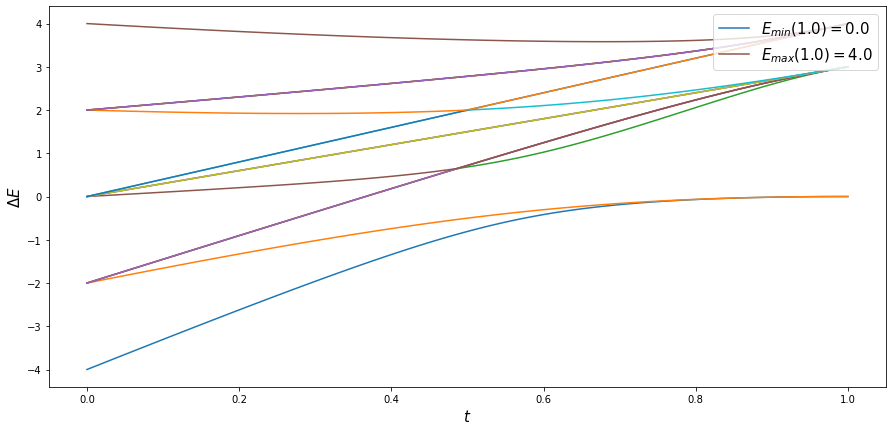

In [17]:
font_size = 15 # label font size
fig = plt.figure(figsize=(15,7))

for i in range(len(t_evals)):
    if i == 0:
        plt.plot(t, t_evals[i], label=r"$E_{min} ($"+str(t[len(t)-1])+"$) = $"+str(round(t_evals[i][len(t)-1],2)))
    elif i == len(t_evals)-1:
        plt.plot(t, t_evals[i], label=r"$E_{max} ($"+str(t[len(t)-1])+"$) = $"+str(round(t_evals[i][len(t)-1],2)))
    else:
        plt.plot(t, t_evals[i])
        
plt.xlabel(r"$t$", fontsize=font_size)
plt.ylabel(r"$\Delta E$", fontsize=font_size)

plt.legend(fontsize=font_size,loc="upper right")
plt.savefig("images/adiabatic_sweep.png", dpi=200)

In [18]:
p = 1
iterations = 100

gamma = np.linspace(0,2*np.pi,iterations)
beta = np.linspace(0,np.pi,iterations)

exp_values = qaoa_protocoll_scanning(H_0, H_p, gamma, beta, p)

max_exp_value = np.max(exp_values)
ind_max_exp_value = np.unravel_index(np.argmax(exp_values), exp_values.shape) # get index of maximum in graph (corresponds to set of angles for which aprrox ratio is maximal)
print(" ")
print("p = ", p)
print("fineness of grid = ", iterations)
print("maximum expectation value = ", max_exp_value)
# print("index of max expectation value = ", ind_max_exp_value)

print(" ")
print("angle values (may be degenerate): ")
for i in range(p):
    print("gamma_"+str(i+1)+" = ", gamma[ind_max_exp_value[i]])
    print("beta_"+str(i+1)+" = ", beta[ind_max_exp_value[i+1]])

 
p =  1
fineness of grid =  100
maximum expectation value =  3.6969740658490045
 
angle values (may be degenerate): 
gamma_1 =  2.6655937666822487
beta_1 =  0.28559933214452665


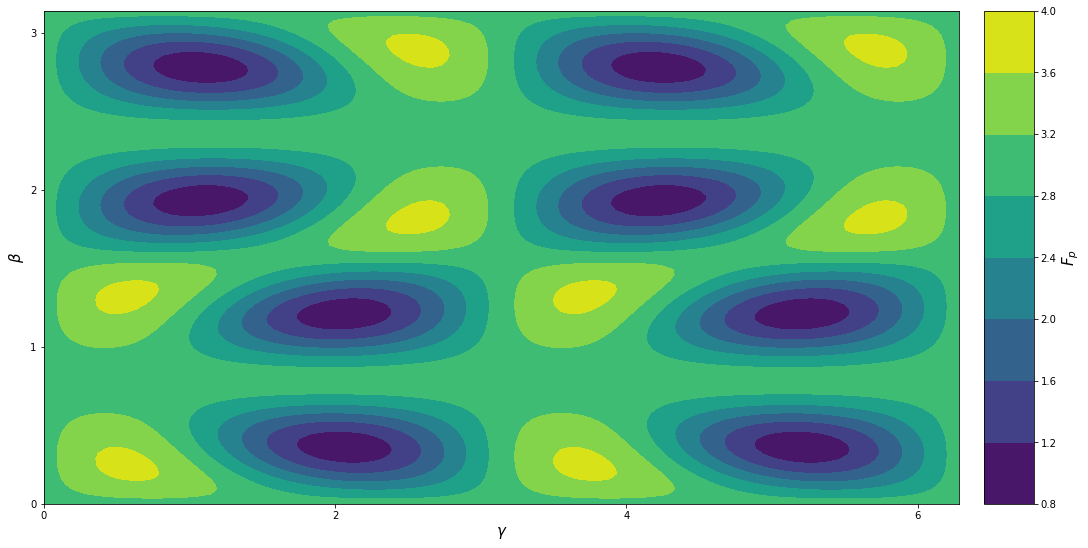

In [19]:
if p == 1:
    font_size = 15 # label font size
    fig, axs = plt.subplots(1,1, constrained_layout=True, figsize=(15,7.5), sharey=True)

    cs = axs.contourf(gamma,beta,exp_values)
    cbar = fig.colorbar(cs, ax=axs)
    cbar.ax.set_ylabel(r'$F_p$', fontsize=font_size)
    axs.locator_params(nbins=4)

    axs.set_xlabel(r"$\gamma$", fontsize=font_size)
    axs.set_ylabel(r"$\beta$", fontsize=font_size)

    plt.savefig("images/contour_plot_qaoa.png", dpi=200)

In [20]:
M_1 = 1000 # number of monte carlo steps
rand_approach = "all_approach" # choose kind of random updating, options: "all_approach", "lechner_approach"
opt_approach = "max" # minimization or maximization: "min", "max"

p_array = np.array([1,2,20]) # illustrate algorithm for three different sizes of angle sets

L = 3

exp_values_1 = np.zeros((L,3,M))

for i in range(L):
    exp_values_p1_1, params_p1_1, entropy_p1_1, fidelity_p1_1, final_state_p1_1 = qaoa_protocoll_montecarlo(H_0, H_p, p_array[0], M_1, rand_approach, opt_approach)
    exp_values_p2_1, params_p2_1, entropy_p2_1, fidelity_p2_1, final_state_p2_1 = qaoa_protocoll_montecarlo(H_0, H_p, p_array[1], M_1, rand_approach, opt_approach)
    exp_values_p3_1, params_p3_1, entropy_p3_1, fidelity_p3_1, final_state_p3_1 = qaoa_protocoll_montecarlo(H_0, H_p, p_array[2], M_1, rand_approach, opt_approach)

In [21]:
M_2 = 1000 # number of monte carlo steps
rand_approach = "all_approach" # choose kind of random updating, options: "all_approach", "lechner_approach"
opt_approach = "max" # minimization or maximization: "min", "max"

p_array = np.array([1,2,20]) # illustrate algorithm for three different sizes of angle sets

exp_values_p1_2, params_p1_2, entropy_p1_2, fidelity_p1_2, final_state_p1_2 = qaoa_protocoll_montecarlo_entropy(H_0, H_p, p_array[0], M_2, rand_approach, opt_approach)
exp_values_p2_2, params_p2_2, entropy_p2_2, fidelity_p2_2, final_state_p2_2 = qaoa_protocoll_montecarlo_entropy(H_0, H_p, p_array[1], M_2, rand_approach, opt_approach)
exp_values_p3_2, params_p3_2, entropy_p3_2, fidelity_p3_2, final_state_p3_2 = qaoa_protocoll_montecarlo_entropy(H_0, H_p, p_array[2], M_2, rand_approach, opt_approach)

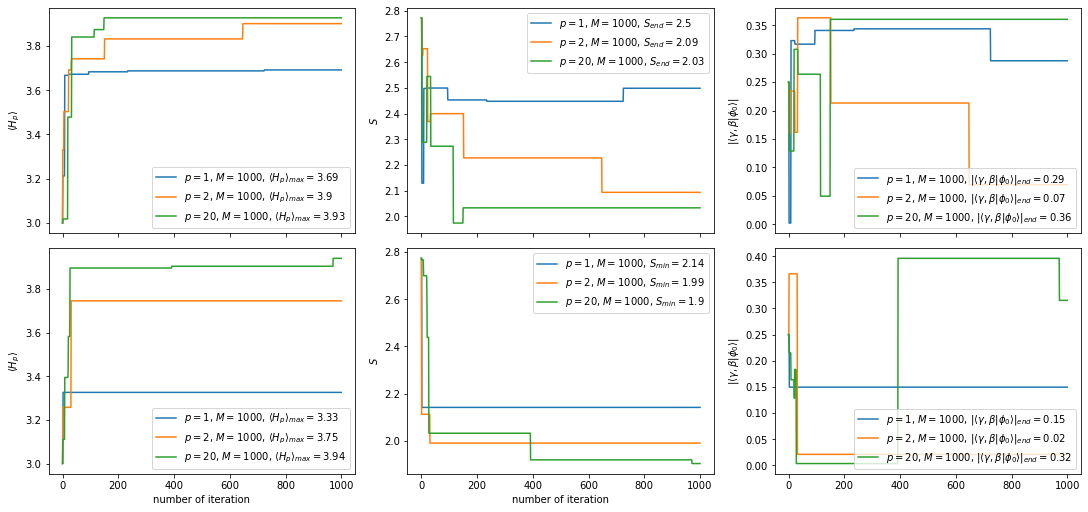

In [29]:
font_size = 10 # label font size
fig, axs = plt.subplots(2,3, constrained_layout=True, figsize=(15,7), sharex=True)

if opt_approach == "max":
    h_p_string = r", $\langle H_p \rangle_{max} = $"
elif opt_approach == "min":
    h_p_string = r", $\langle H_p \rangle_{min} = $"

s_p_string_1 = r", $S_{end} = $"
s_p_string_2 = r", $S_{min} = $"
f_p_string = r", $|\langle \gamma,\beta |\phi_0\rangle|_{end} = $"

# plot energy values if no additional entropy minimization has been performed
axs[0,0].plot(np.arange(M_1+1),exp_values_p1_1, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_1)+h_p_string+str(round(exp_values_p1_1[M_1-1],2)))
axs[0,0].plot(np.arange(M_1+1),exp_values_p2_1, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_1)+h_p_string+str(round(exp_values_p2_1[M_1-1],2)))
axs[0,0].plot(np.arange(M_1+1),exp_values_p3_1, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_1)+h_p_string+str(round(exp_values_p3_1[M_1-1],2)))
axs[0,0].legend(fontsize=font_size, loc="lower right")
axs[0,0].set_ylabel(r"$\langle H_p \rangle$", fontsize=font_size)

# plot energy values if additional entropy minimization has been performed
axs[1,0].plot(np.arange(M_2+1),exp_values_p1_2, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_2)+h_p_string+str(round(exp_values_p1_2[M_2-1],2)))
axs[1,0].plot(np.arange(M_2+1),exp_values_p2_2, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_2)+h_p_string+str(round(exp_values_p2_2[M_2-1],2)))
axs[1,0].plot(np.arange(M_2+1),exp_values_p3_2, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_2)+h_p_string+str(round(exp_values_p3_2[M_2-1],2)))
axs[1,0].legend(fontsize=font_size, loc="lower right")
axs[1,0].set_xlabel(r"number of iteration", fontsize=font_size)
axs[1,0].set_ylabel(r"$\langle H_p \rangle$", fontsize=font_size)

# plot entropy values if no additional entropy minimization has been performed
axs[0,1].plot(np.arange(M_1+1),entropy_p1_1, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_1)+s_p_string_1+str(round(entropy_p1_1[M_1-1],2)))
axs[0,1].plot(np.arange(M_1+1),entropy_p2_1, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_1)+s_p_string_1+str(round(entropy_p2_1[M_1-1],2)))
axs[0,1].plot(np.arange(M_1+1),entropy_p3_1, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_1)+s_p_string_1+str(round(entropy_p3_1[M_1-1],2)))
axs[0,1].legend(fontsize=font_size, loc="upper right")
axs[0,1].set_ylabel(r"$S$", fontsize=font_size)

# plot entropy values if additional entropy minimization has been performed
axs[1,1].plot(np.arange(M_2+1),entropy_p1_2, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_2)+s_p_string_2+str(round(entropy_p1_2[M_2-1],2)))
axs[1,1].plot(np.arange(M_2+1),entropy_p2_2, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_2)+s_p_string_2+str(round(entropy_p2_2[M_2-1],2)))
axs[1,1].plot(np.arange(M_2+1),entropy_p3_2, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_2)+s_p_string_2+str(round(entropy_p3_2[M_2-1],2)))
axs[1,1].legend(fontsize=font_size, loc="upper right")
axs[1,1].set_xlabel(r"number of iteration", fontsize=font_size)
axs[1,1].set_ylabel(r"$S$", fontsize=font_size)

# plot fidelity during iterations if no additional entropy minimzation has been performed
axs[0,2].plot(np.arange(M_1+1),fidelity_p1_1, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_1)+f_p_string+str(round(fidelity_p1_1[M_1-1],2)))
axs[0,2].plot(np.arange(M_1+1),fidelity_p2_1, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_1)+f_p_string+str(round(fidelity_p2_1[M_1-1],2)))
axs[0,2].plot(np.arange(M_1+1),fidelity_p3_1, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_1)+f_p_string+str(round(fidelity_p3_1[M_1-1],2)))
axs[0,2].legend(fontsize=font_size, loc="lower right")
axs[0,2].set_ylabel(r"$|\langle \gamma,\beta |\phi_0\rangle|$", fontsize=font_size)

# plot fidelity during iterations if additional entropy minimzation has been performed
axs[1,2].plot(np.arange(M_2+1),fidelity_p1_2, label=r"$p = $"+str(p_array[0])+", $M = $"+str(M_2)+f_p_string+str(round(fidelity_p1_2[M_2-1],2)))
axs[1,2].plot(np.arange(M_2+1),fidelity_p2_2, label=r"$p = $"+str(p_array[1])+", $M = $"+str(M_2)+f_p_string+str(round(fidelity_p2_2[M_2-1],2)))
axs[1,2].plot(np.arange(M_2+1),fidelity_p3_2, label=r"$p = $"+str(p_array[2])+", $M = $"+str(M_2)+f_p_string+str(round(fidelity_p3_2[M_2-1],2)))
axs[1,2].legend(fontsize=font_size, loc="lower right")
axs[1,1].set_xlabel(r"number of iteration", fontsize=font_size)
axs[1,2].set_ylabel(r"$|\langle \gamma,\beta |\phi_0\rangle|$", fontsize=font_size)

plt.savefig("images/energy_entropy_comparison_montecarlo_"+rand_approach+"_"+opt_approach+".png", dpi=200)

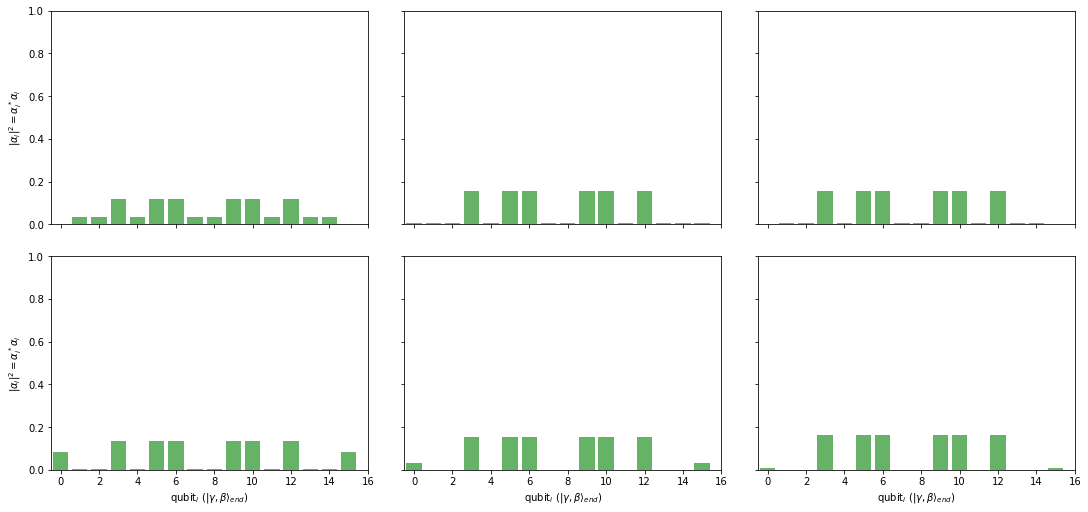

In [23]:
font_size = 10 # label font size
fig, axs = plt.subplots(2,3, constrained_layout=True, figsize=(15,7), sharex=True, sharey=True)

plot_fock_distribution(final_state_p1_1, fig=fig, ax=axs[0,0])
plot_fock_distribution(final_state_p2_1, fig=fig, ax=axs[0,1])
plot_fock_distribution(final_state_p3_1, fig=fig, ax=axs[0,2])

plot_fock_distribution(final_state_p1_2, fig=fig, ax=axs[1,0])
plot_fock_distribution(final_state_p2_2, fig=fig, ax=axs[1,1])
plot_fock_distribution(final_state_p3_2, fig=fig, ax=axs[1,2])

axs[0,0].set_ylabel(r"$|\alpha_i|^2 = \alpha^*_i \alpha_i$", fontsize=font_size)
axs[1,0].set_ylabel(r"$|\alpha_i|^2 = \alpha^*_i \alpha_i$", fontsize=font_size)

axs[1,0].set_xlabel(r"qubit$_i$ ($|\gamma,\beta\rangle_{end}$)", fontsize=font_size)
axs[1,1].set_xlabel(r"qubit$_i$ ($|\gamma,\beta\rangle_{end}$)", fontsize=font_size)
axs[1,2].set_xlabel(r"qubit$_i$ ($|\gamma,\beta\rangle_{end}$)", fontsize=font_size)

# due to plot_fock_distribution function the labels have to be set to zero explicitly
axs[0,0].set_xlabel(" ")
axs[0,1].set_xlabel(" ")
axs[0,2].set_xlabel(" ")
axs[0,1].set_ylabel(" ")
axs[0,2].set_ylabel(" ")
axs[1,1].set_ylabel(" ")
axs[1,2].set_ylabel(" ")

plt.savefig("images/fock_distribution_final_states_comparison_montecarlo_"+rand_approach+"_"+opt_approach+".png", dpi=200)

In [18]:
exp_values_p1_1 = np.zeros((3,3,3))

In [19]:
exp_values_p1_1[0] = np.array([1,2,3])

In [21]:
exp_values_p1_1[0,1]

array([1., 2., 3.])